# Обработка лабораторной работы 5.5

In [165]:
# Импротируем необходимые функции
import numpy as np # работа с массивами и линейной алгеброй
import matplotlib.pyplot as plt # для отрисовки графиков
import pandas as pd # для чтения и работы с данными
import math
from scipy.optimize import curve_fit # фитирующая процедура

In [136]:
def read_file(path):
    df = pd.read_excel(path)
    df = df.drop(df.index[[0,1,2,3,4]])
    df.columns = ['Channel', 'Counts']
    df.index = np.arange(0, len(df))
    df['Counts'] = df['Counts'].apply(np.float64)
    df['Channel'] = df['Channel'].apply(np.float64)
    df['Error'] = df['Counts']
    df['Error'] = df['Error'].apply(np.sqrt)
    return df

def draw(df, title, err = False):
    x = df["Channel"]
    y = df["Counts"]
    plt.figure(figsize=(15,7))
    if(err):
        plt.errorbar(x, y, yerr=df['Error'], color = "green")
        plt.scatter(x, y, label='Data')
    else:
        plt.plot(x, y, label='Data')
    plt.title(title)
    plt.legend()
    plt.grid() # Активирует сетку
    plt.show()

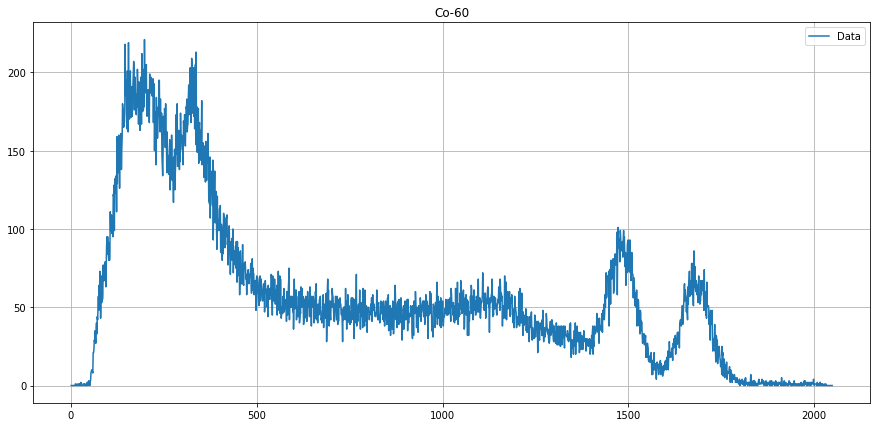

In [137]:
# Импорт данных (поработаем пока с Co-60)
data_co = read_file('data/excel/Co60.xlsx')
draw(data_co, 'Co-60')

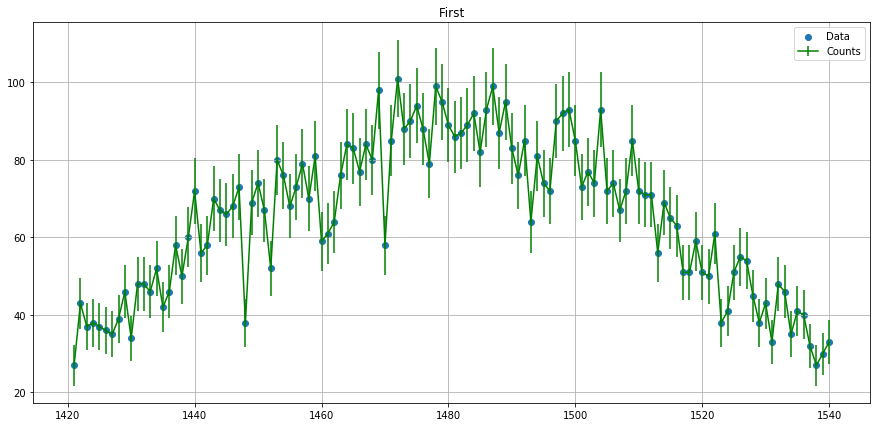

In [138]:
# Выделим первый пик
delta_1 = 1420
delta_2 = 1540

data_co_f = data_co.iloc[delta_1:delta_2]
draw(data_co_f, 'First', True)

In [178]:
def gauss_function(x, a, x0, s):
    return a*np.exp(-(x-x0)**2/(2*s**2))
def gauss_function_c(x, a, x0, s, c):
    return a*np.exp(-(x/1000.0-x0)**2/(2*s**2)) + c
def parabolla(x, a, b, c):
    return a*x**2 + b*x + c

In [179]:
def fit(df, f, err_draw = True, err = True, norm = True):
    x = df['Channel']
    y = df['Counts']
    yerr = df['Error']
    
    if (norm):
        x_n = (x - x.mean())/np.sqrt(x.var())
    else:
        x_n = x
    if (err):
        popt, pcov = curve_fit(f = f, xdata= x_n, ydata=y, maxfev=10000, sigma = yerr)
    else:
        popt, pcov = curve_fit(f = f, xdata= x_n, ydata=y, maxfev=10000)
    plt.figure(figsize= (7,7)) # Настраиваем размер холста
    if (err_draw):
        plt.scatter(x_n, y, label='Data')
        plt.errorbar(x_n, y, yerr = yerr, color = "orange")
        plt.plot(x_n, f(x_n, *popt), label='res', color = 'black') # Строим график
    else:
        plt.plot(x_n, y, label='Data')
        plt.plot(x_n, f(x_n, *popt), label='res', color = 'black') # Строим график
    plt.legend(); # Активируем легенду
    plt.show()
    
    pik = popt[1]*np.sqrt(x.var())+x.mean()
    pik_s = np.sqrt(popt[2])*np.sqrt(x.var())
    
    return popt, pcov, pik, pik_s

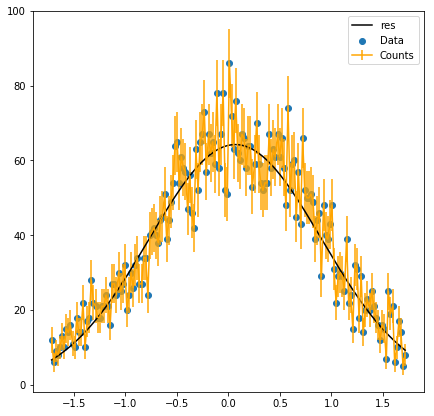

(1678.8256034535104, 45.059737559351575)


In [180]:
popt_g, pcov_g, pik1_g, pik1_s_g = fit(data_co_f, gauss_function)
print(pik1_g, pik1_s_g)

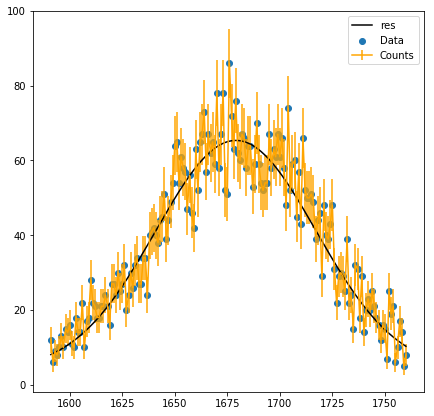

(1758.1416920108591, 9.619276638118075)


array([  6.15698790e+01,   1.67906422e+00,   3.81962778e-02,
         3.78915609e+00])

In [185]:
popt_g_c, pcov_g_c, pik1_g, pik1_s_g = fit(data_co_f, gauss_function_c, norm = False)
print(pik1_g, pik1_s_g)
popt_g_c

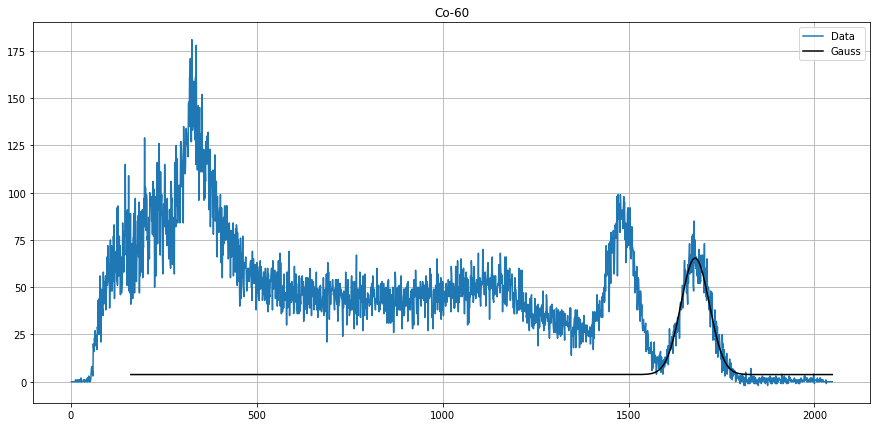

In [191]:
    x = data_co["Channel"]
    y = data_co["Counts"]
    plt.figure(figsize=(15,7))
    plt.plot(x, y, label='Data')
    plt.plot(x[delta_1:delta_2], gauss_function_c(x[delta_1:delta_2], *popt_g_c), label = 'Gauss', color = 'black')
    plt.title('Co-60')
    plt.legend()
    plt.grid() # Активирует сетку
    plt.show()

Фитируем параболой

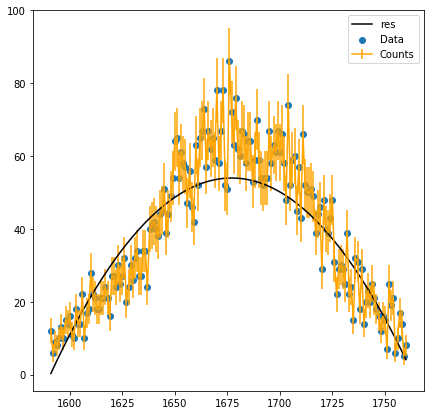

(2872.0966887366289, nan)


D:\PF\Anaconda2\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


array([ -7.24834916e-03,   2.43117322e+01,  -2.03320592e+04])

In [164]:
popt_p, pcov_p, pik1_p, pik1_s_p = fit(data_co_f, parabolla, norm = False)
print(pik1_p, pik1_s_p)
popt_p

Видим, что фитирование лучше прошло с нормальным распределением, тем более погрешность практически не возросла.
Поработаем теперь со вторым пиком.

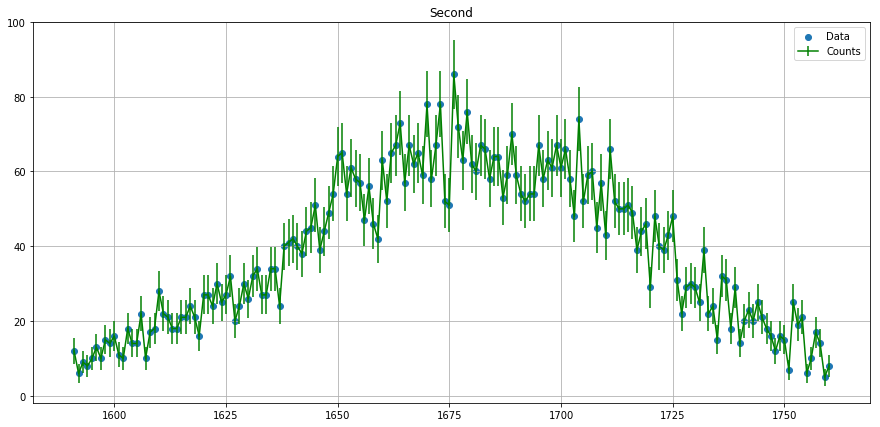

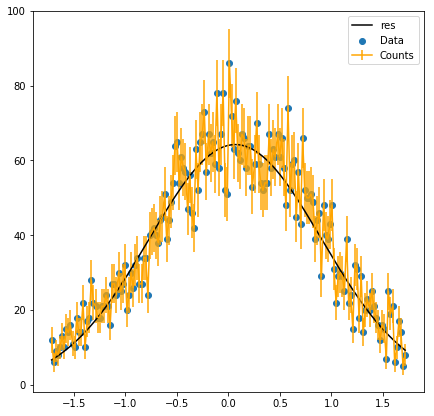

(1678.8256034535104, 45.059737559351575)


In [143]:
# Выделим второй пик
delta_1 = 1590
delta_2 = 1760

data_co_f = data_co.iloc[delta_1:delta_2]
draw(data_co_f, 'Second', True)

popt_g, pcov_g, pik2_g, pik2_s_g = fit(data_co_f, gauss_function)
print(pik2_g, pik2_s_g)

## Посмотрим, что из себя представляет фон

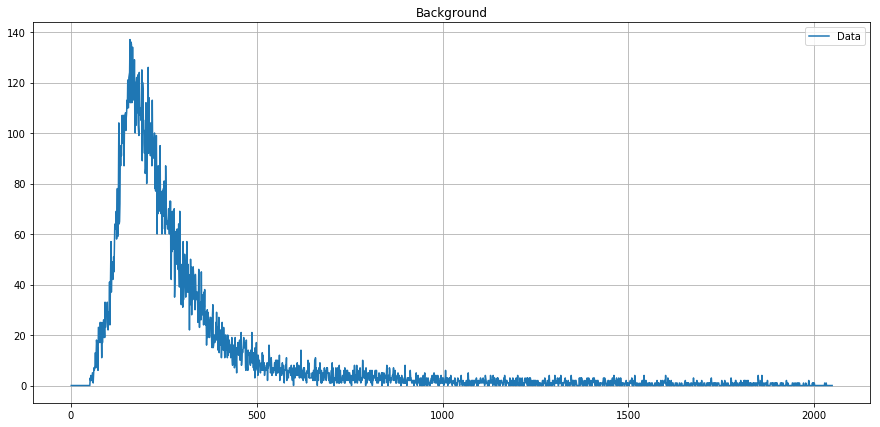

In [144]:
data_b = read_file('data/excel/background.xlsx')
data_b.head()
draw(data_b, 'Background')

Профитируем фон экспонентой

In [145]:
def exp(x, a, b, x0):
    return a*np.exp(-b*(x-x0))

In [146]:
delta_1 = 160
delta_2 = len(data_b)
data_b_exp = data_b.iloc[delta_1:delta_2]

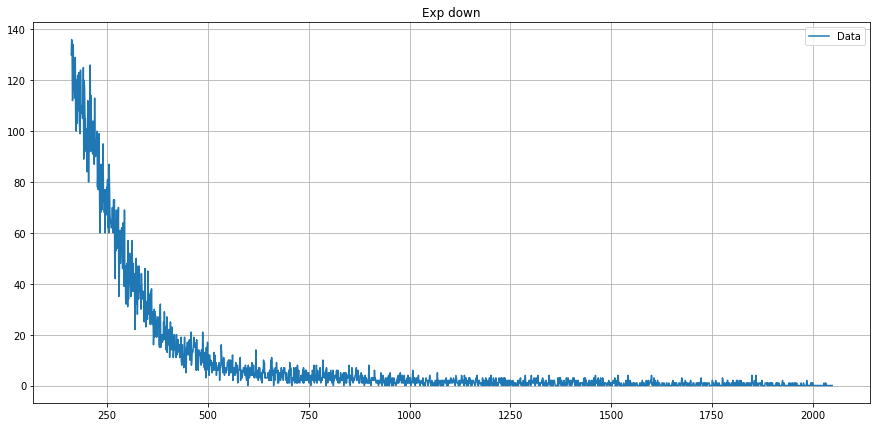

In [147]:
draw(data_b_exp, 'Exp down')

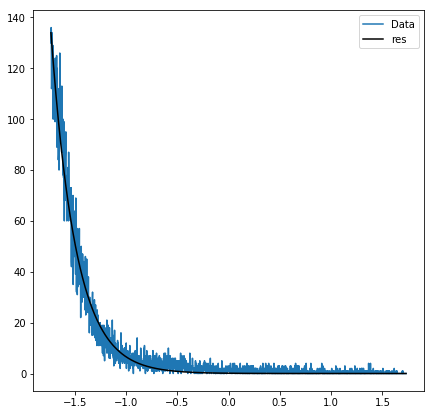

In [148]:
popt_exp, pcov_exp, _, __ = fit(data_b_exp, exp, err= False, err_draw= False)

Посмотрим на спектр цезия

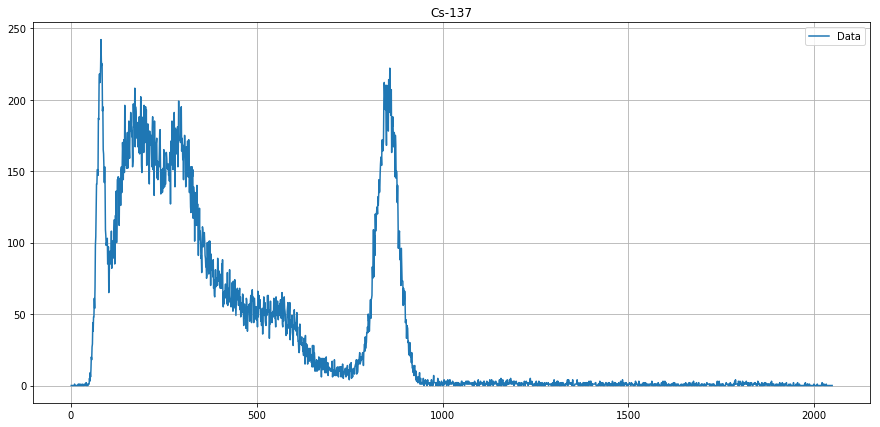

In [152]:
data_cs = read_file('data/excel/Cs137.xlsx')
draw(data_cs, 'Cs-137')

Теперь натрий

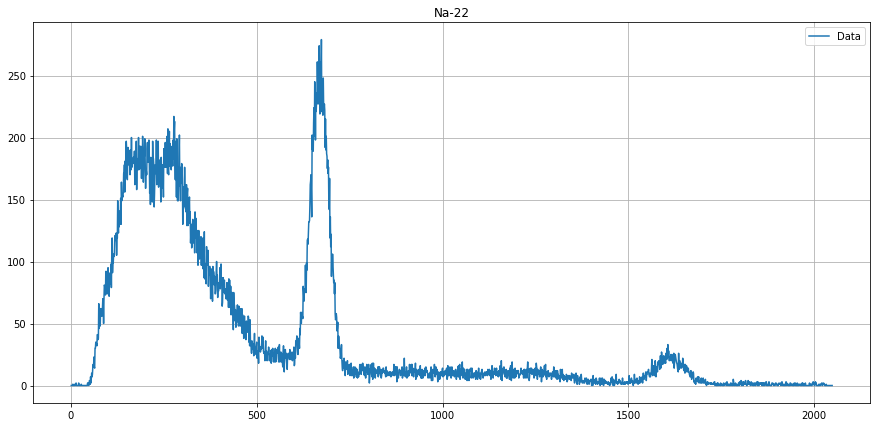

In [153]:
data_na = read_file('data/excel/Na22.xlsx')
draw(data_na, 'Na-22')

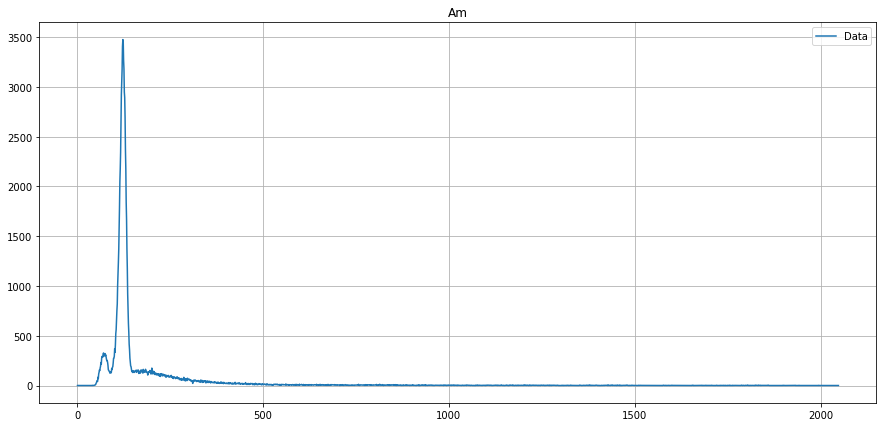

In [193]:
data_am = read_file('data/excel/Am241.xlsx')
draw(data_am, 'Am')

Посмотрим, что будет, если вычесть фон из данных по кобальту?

In [149]:
data_m = data_co
data_m["Counts"] = data_co['Counts'] - data_b['Counts']
data_m['Error'] = np.sqrt(data_co['Error']**2 + data_b['Error']**2)

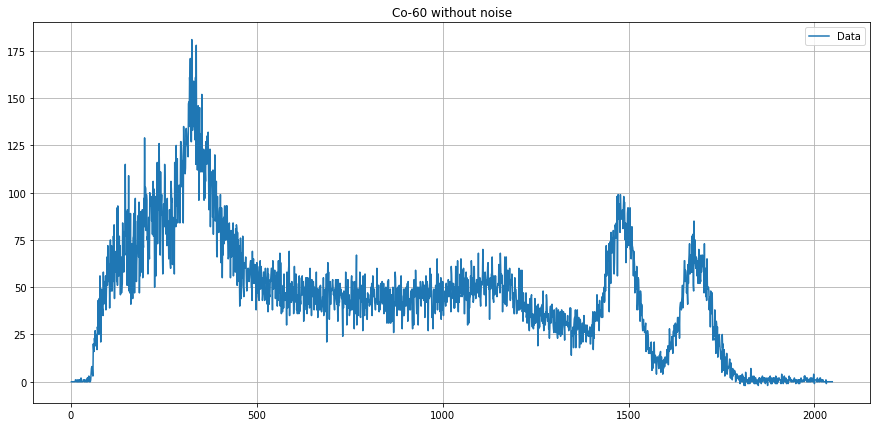

In [150]:
draw(data_m, "Co-60 without noise")